In [ ]:
# This script will compare buy & sells of a given stock relative to the price action, 
# It is designed to analyze when I bought & sold a stock (Daytrading) vs the price action. 
# April 2025


# Set up

In [187]:
import pandas as pd
import plotnine as p9
import yfinance as yf
from datetime import datetime, timedelta
import json
import unittest
import requests
import configparser


In [191]:
config = configparser.ConfigParser()
config.sections()
config.read('DayTrade_analysis.ini')
ALPHA_ADVANTAGE_KEY = config['KEYS']['ALPHA_ADVANTAGE_KEY']


In [510]:

class TestComputeSummary(unittest.TestCase):
    def setUp(self):
        # Sample data for testing
        self.df = pd.DataFrame({
            'Date': ['2025-05-09', '2025-05-09', '2025-05-09', '2025-05-09'],
            'Success': [True, False, True, False],
            'Stock_Total_Gain': [10.0, -5.0, 15.0, -10.0],
            'Stock_pShare_Gain': [2.0, -1.0, 3.0, -2.0]
        })

    def test_compute_summary(self):
        result = compute_summary(self.df)

        # Test daily summary
        daily_summary = result['daily_summary']
        self.assertEqual(len(daily_summary), 1)
        self.assertAlmostEqual(daily_summary['Daily_accuracy'].iloc[0], 0.5)
        self.assertAlmostEqual(daily_summary['Daily_total_gain'].iloc[0], 10.0)
        self.assertAlmostEqual(daily_summary['Daily_avg_gain'].iloc[0], 2.5)
        self.assertAlmostEqual(daily_summary['Daily_total_gain_per_share'].iloc[0], 2.0)

        # Test overall summary
        overall_summary = result['overall_summary']
        self.assertAlmostEqual(overall_summary['Overall_accuracy'].iloc[0], 0.5)
        self.assertAlmostEqual(overall_summary['Overall_total_gain'].iloc[0], 10.0)
        self.assertAlmostEqual(overall_summary['Overall_avg_gain'].iloc[0], 2.5)
        self.assertAlmostEqual(overall_summary['Overall_total_gain_per_share'].iloc[0], 2.0)

if __name__ == '__main__':
    unittest.main()

usage: ipykernel_launcher.py [-h] [-v] [-q] [--locals] [--durations N] [-f]
                             [-c] [-b] [-k TESTNAMEPATTERNS]
                             [tests ...]
ipykernel_launcher.py: error: argument -f/--failfast: ignored explicit argument '/Users/stevensmith/Library/Jupyter/runtime/kernel-v31b2c6f959dafaa9cc4e5b04521a9c71c80bac941.json'


SystemExit: 2

/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/IPython/core/interactiveshell.py:3678: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.


# Function definitions

In [ ]:



def filter_time_window(data, universal_time_col='Datetime', filtering_time_col="FilledTime", units = "m",time_buffer=10):
    """
    Filter the data to include rows within a time interval of +/- time_buffer_minutes.

    Parameters:
    - data (pd.DataFrame): The input DataFrame containing a time column.
    - time_column (str): The name of the time column in the DataFrame.
    - time_buffer_minutes (int): The number of minutes to extend the time range.

    Returns:
    - pd.DataFrame: A filtered DataFrame within the specified time interval.
    """
    min_time = data[filtering_time_col].min() - pd.Timedelta(time_buffer,unit=units)
    max_time = data[filtering_time_col].max() + pd.Timedelta(time_buffer,unit=units)
    return data[(data[universal_time_col] >= min_time) & (data[universal_time_col] <= max_time)]


def format_orders(df):
    """
    Format the stock orders DataFrame by converting date columns to datetime and renaming columns.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame containing stock order records.
    
    Returns:
    - pd.DataFrame: The formatted DataFrame with renamed columns and datetime conversions.
    """
    #df.rename(columns={'Placed Time': 'PlacedTime', 'Symbol': 'Symbol', 'Side': 'Side', 'Avg Price': 'Avg Price'})
    df['Placed Time'] = pd.to_datetime(df['Placed Time'].str.replace(" EDT",""), format="%m/%d/%Y %H:%M:%S").dt.tz_localize('America/New_York')
    df['Filled Time'] = pd.to_datetime(df['Filled Time'].str.replace(" EDT",""), format="%m/%d/%Y %H:%M:%S").dt.tz_localize('America/New_York')

    df['Date'] = df['Placed Time'].dt.date
    df['Time'] = df['Placed Time'].dt.time    

    df['UID'] = df['Symbol'].astype(str) + "_" + df['Placed Time'].astype(str)
    
    df.rename(columns={'Order ID': 'OrderID', 'Symbol': 'Symbol', 'Side': 'Side', 'Avg Price': 'AvgPrice', 
                       'Quantity': 'Quantity', 'Status': 'Status', 'Placed Time': 'PlacedTime', 
                       'Filled Time': 'FilledTime'}, inplace=True)
    

    # Filter rows where the 'status' column is 'Filled'
    #filled_orders['FilledTime_dt']=pd.to_datetime(filled_orders['Filled Time'].str.replace(" EDT",""), format="%m/%d/%Y %H:%M:%S")
    #filled_orders['FilledTime_dt_ny'] = filled_orders['FilledTime_dt'].dt.tz_localize('America/New_York')
    #filled_orders.pivot(index=['Symbol', 'Placed Time'], columns='Side', values='Avg Price').reset_index()

    return df


def filter_stock_orders(df, cutoff_date=None,days=10):
    """
    Filter the stock orders DataFrame to include only filled orders within a specific time window.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame containing stock order records.
    
    Returns:
    - pd.DataFrame: The filtered DataFrame with filled orders within the specified time window.
    """

    if cutoff_date is None:
        cutoff_date = datetime.now() - timedelta(days=days)
        cutoff_date = pd.to_datetime(cutoff_date,format="%m/%d/%Y %H:%M:%S").tz_localize('America/New_York')
    
    # Filter the DataFrame for filled orders within the specified time window
    filtered_df = df[df['FilledTime'] > cutoff_date]
    
    return filtered_df

def pair_buy_sell(filled_orders_filtered):
    filled_orders_wide=filled_orders_filtered.pivot(index=['Symbol', 'PlacedTime'], values=['AvgPrice','FilledTime'], columns='Side').reset_index()#.rename(columns={'Buy': 'BuyTime', 'Sell': 'SellTime'})
    test_out = filled_orders_wide.columns.values
    filled_orders_wide.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in filled_orders_wide.columns.values]
    filled_orders_wide.rename(columns={'Symbol_': 'Symbol', 'PlacedTime_': 'PlacedTime'}, inplace=True)

    #filled_orders_wide = filled_orders_filtered.pivot(index=['Symbol', 'PlacedTime'], columns='Side', values='AvgPrice').reset_index()
    filled_orders_wide.sort_values(by=['Symbol', 'PlacedTime'], inplace=True)

    # Forward fill 'Buy' and backward fill 'Sell' to pair sequential times
    #AvgPrice_Buy	AvgPrice_Sell	FilledTime_Buy	FilledTime_Sell
    filled_orders_wide['Buy_Time_MM']=filled_orders_wide['AvgPrice_Buy'].isna()
    filled_orders_wide['Sell_Time_MM']=filled_orders_wide['AvgPrice_Sell'].isna()
    filled_orders_wide['AvgPrice_Buy'] = filled_orders_wide['AvgPrice_Buy'].fillna(method='ffill')
    filled_orders_wide['AvgPrice_Sell'] = filled_orders_wide['AvgPrice_Sell'].fillna(method='bfill')
    filled_orders_wide['UID'] = filled_orders_wide['Symbol'].astype(str) + "_" + filled_orders_wide['PlacedTime'].astype(str)

    filled_orders_wide.drop(columns=['Symbol','PlacedTime'], inplace=True)


    return filled_orders_wide,test_out


def pair_buy_sell_mlindx(filled_orders_filtered):
    filled_orders_wide=filled_orders_filtered.pivot(index=['Symbol', 'PlacedTime'], values=['AvgPrice','FilledTime'], columns='Side').reset_index()#.rename(columns={'Buy': 'BuyTime', 'Sell': 'SellTime'})
    test_out = filled_orders_wide.columns.values
    #filled_orders_wide.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in filled_orders_wide.columns.values]
    #filled_orders_wide.rename(columns={'Symbol_': 'Symbol', 'PlacedTime_': 'PlacedTime'}, inplace=True)

    #filled_orders_wide = filled_orders_filtered.pivot(index=['Symbol', 'PlacedTime'], columns='Side', values='AvgPrice').reset_index()
    filled_orders_wide.sort_values(by=[('Symbol',), ('PlacedTime',)], inplace=True)

    # Forward fill 'Buy' and backward fill 'Sell' to pair sequential times
    #AvgPrice_Buy	AvgPrice_Sell	FilledTime_Buy	FilledTime_Sell
    #TODO: test this on data without OCO orders. This should still work assuming an outstanding order is closed before another one opened. 
    #However this may not work with partial sells. 
    # Why are we doing a wide pivot here? It is only to make stats easier to compute. However, stats can be computed in aggregate. 
    filled_orders_wide[('TimeMM','Buy')]=filled_orders_wide[('AvgPrice','Buy')].isna()
    filled_orders_wide[('TimeMM','Sell')]=filled_orders_wide[('AvgPrice','Sell')].isna()
    filled_orders_wide[('AvgPrice','Buy')] = filled_orders_wide[('AvgPrice','Buy')].fillna(method='ffill')
    filled_orders_wide[('AvgPrice','Sell')] = filled_orders_wide[('AvgPrice','Sell')].fillna(method='bfill')
    filled_orders_wide[('UID','')] = filled_orders_wide[('Symbol',)].astype(str) + "_" + filled_orders_wide[('PlacedTime',)].astype(str)

    filled_orders_wide.drop(columns=[('Symbol',),('PlacedTime',)], inplace=True)


    return filled_orders_wide,test_out


def compute_stats(df):

    df['Gain_per_share'] = df['AvgPrice_Sell'] - df['AvgPrice_Buy']
    df['Gain_total'] = df['Gain_per_share'] * df['Filled']
    df['Success'] = df['Gain_total'] > 0

    return df


def compute_stats_long(df):
    # compute total gains - for each share & day, sum up the price * shares (sell - buy)
    #shares * sell - shares * buy = (shres1* buy1) - (shres2*sell2) - (shares3*price3)
    #Name	Symbol	Side	Status	Filled	Total Qty	Price	AvgPrice	Time-in-Force	PlacedTime	FilledTime	Date	Time	UID
    df.loc[df['Side'] == 'Buy','AvgPrice'] = -df.loc[df['Side'] == 'Buy','AvgPrice']
  
    df['Total_Price'] = df['Filled'] * df['AvgPrice'] 
    df_summary = df.groupby(['Symbol','Date']).agg({'Total_Price':'sum','AvgPrice':'sum'}).reset_index().rename(columns={'Total_Price':'Stock_Total_Gain','AvgPrice':'Stock_pShare_Gain'})
    df_summary['Success'] = df_summary['Stock_Total_Gain']>0 #filled_orders_w_stats = compute_stats_long(filled_orders_filtered)
    
    return df, df_summary

# def compute_stats_mlindx(df):
#     df[('Gain_per_share','computed')] = df[('AvgPrice','Sell')] - df[('AvgPrice','Buy')]
#     df[('Gain_total','computed')] = df[('Gain_per_share','computed')] * df[('Filled',)]
#     df[('Success','computed')] = df[('Gain_total','computed')] > 0

#     return df




def generate_candlestick_plot(stock_order_df, timedata_width=2.5, date = "", stock_symbol=""):
    """
    Generate a candlestick plot using plotnine.

    Parameters:
    - stock_order_df (pd.DataFrame): A DataFrame containing stock data with columns 'Datetime', 'Open', 'High', 'Low', and 'Close' and stock buy/sell orders.

    Returns:
    - plotnine.ggplot.ggplot: A candlestick plot.
    
    """

    interval = timedata_width * 2
    stock_order_df["hour_min"] = stock_order_df['Datetime'].dt.strftime('%H:%M:%S') #TODO figure out a way to use hour_min in x axis
    candlestick_plot = (
        p9.ggplot(stock_order_df, p9.aes(x='Datetime')) +
        p9.geom_segment(p9.aes(x='Datetime', xend='Datetime', y='Low', yend='High'), color='black') +

        p9.geom_rect(
            p9.aes(
            xmin=f"Datetime - pd.Timedelta(minutes={timedata_width})",
            xmax=f"Datetime + pd.Timedelta(minutes={timedata_width})", 
            ymin='Open', 
            ymax='Close', 
            fill='Close > Open'
            ),
            color='black'
        ) +
        p9.geom_point(p9.aes(x='Datetime', y='AvgPrice', color="Side"), size=2) +
        p9.scale_fill_manual(values={True: 'green', False: 'red'}) +
        p9.scale_color_manual(values={"Buy": 'blue', "Sell": 'orange'}) +
        p9.labs(title="Candlestick Chart", x="Datetime", y="Price") +
        p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=1)) +
        p9.scale_x_datetime(date_breaks='5 minutes', date_labels='%H:%M') +
        p9.ggtitle(f"Candlestick Chart for {stock_symbol} on {date} @ {interval} min interval")
        )   
    candlestick_plot.save(f"candlestick_plot_{date}_{stock_symbol}_{interval}mins.png", dpi=300)
    return candlestick_plot




def compute_summary(df):

    # Compute daily accuracy
    daily_success = df.groupby('Date')['Success'].sum().reset_index(name='Daily_success')
    total_trades = df.groupby('Date')['Success'].count().reset_index(name='Total_trades')
    daily_accuracy = daily_success.merge(total_trades, on='Date')
    daily_accuracy['Daily_accuracy'] = daily_accuracy['Daily_success'] /daily_accuracy['Total_trades']  #df.groupby('Date').apply(lambda x: x['Success'].sum() / len(x)).reset_index(name='Daily_accuracy')


    #daily_accuracy_detailed = daily_accuracy.merge(daily_success, on='Date').merge(total_trades, on='Date')

    # Compute daily total gain
    daily_total_gain = df.groupby('Date')['Stock_Total_Gain'].sum().reset_index(name='Daily_total_gain')

    # Compute per-share total gain 
    daily_total_gain_normalized = df.groupby('Date')['Stock_pShare_Gain'].sum().reset_index(name='Daily_total_gain_per_share')


    # Compute daily average gain
    daily_avg_gain = df.groupby('Date')['Stock_Total_Gain'].mean().reset_index(name='Daily_avg_gain')


    # Merge all summaries into a single DataFrame
    daily_summary = daily_accuracy.merge(daily_total_gain).merge(daily_avg_gain).merge(
        daily_total_gain_normalized)


    # compute overalls: 
    overall_accuracy = df['Success'].sum() / len(df['Success'])
    overall_total_gain = df['Stock_Total_Gain'].sum()
    overall_total_gain_per_share = df['Stock_pShare_Gain'].sum()
    overall_avg_gain = df['Stock_Total_Gain'].mean()
    overall_summary = pd.DataFrame({
        'Overall_accuracy': [overall_accuracy],
        'Overall_total_gain': [overall_total_gain],
        'Overall_avg_gain': [overall_avg_gain],
        'Overall_total_gain_per_share': [overall_total_gain_per_share],
    })


    return {'daily_summary': daily_summary,'overall_summary': overall_summary}


def flatten_columns(df,delimiter='_',rename_mapping=None):  
    """
    Flatten the multi-level columns of a DataFrame into single-level columns.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame with multi-level columns.
    - delimiter (str): The delimiter to use for flattening the columns (default is '_').
    - rename_mapping (dict): Optional mapping to rename columns after flattening.
    
    Returns:
    - pd.DataFrame: The DataFrame with flattened columns and optional renaming.
    """

    df.columns = [delimiter.join(filter(None, col)).strip() for col in df.columns.values]
    if rename_mapping is not None:
        df.rename(columns=rename_mapping, inplace=True)
    return df

def get_stock_data_wrapper(symbol, start_date, end_date, stock_interval="1m",download_file_path=None,dl_info=False,load_from_file = None):
    if load_from_file is not None:
        try:
            # Load the data from the specified file
            print("Downloading from previous download")
            # get the dtypes from the previously saved file
            with open(load_from_file.replace(".tsv", "_dtypes.json"), "r") as dtype_file:
                dtypes_dict = json.load(dtype_file)
            print(dtypes_dict)
            # re-load the data with the dtypes
            print("reloading data with dtypes")
            dtypes_dict_global = {'Datetime': 'datetime64[ns, America/New_York]',
                                  'Open': 'float64',
                                    'High': 'float64',
                                    'Low': 'float64',
                                    'Close': 'float64',
                                    'Volume': 'int64',
                                    'Dividends': 'float64',
                                    'Stock Splits': 'float64'}
            stock_df = pd.read_csv(load_from_file, sep="\t",dtype=dtypes_dict_global,parse_dates=['Datetime'])

            return stock_df
        except FileNotFoundError:
            print(f"File {load_from_file} not found. Please check the file path. Will attempt to download data from yFinance.")
            return get_stock_data(symbol=symbol, start_date=start_date, end_date=end_date, stock_interval=stock_interval,
                       download_file_path=download_file_path,dl_info=dl_info)
            
    else:
        print("Downloading from yFinance")
        return get_stock_data(symbol=symbol, start_date=start_date, end_date=end_date, stock_interval=stock_interval,
                       download_file_path=download_file_path,dl_info=dl_info)

def get_stock_data(symbol, start_date, end_date, stock_interval="1m",download_file_path=None,dl_info=False):
    """
    Fetch historical stock data for a given symbol and date range.
    
    Parameters:
    - symbol (str): The stock symbol to fetch data for.
    - start_date (str): The start date in 'YYYY-MM-DD' format.
    - end_date (str): The end date in 'YYYY-MM-DD' format. 
    - stock_interval (str): The interval for the stock data (default is '1m'). TODO: data validation e.g. '1m', '5m', '15m', '1h', '1d'.
    - download_file_path (str): Optional file path to save the downloaded data as a TSV file.
    - dl_info (bool): Optional flag to save additional information about the downloaded data in a JSON file. 'download_file_path' must be provided for this to work.
    
    Returns:
    - pd.DataFrame: A DataFrame containing the historical stock data. Also saves the data to a TSV file if download_file_path is provided.
    """

    stock_data = yf.Ticker(symbol)
    stock_info = stock_data.info
    try:
        stock_df = stock_data.history(period="1d", interval=stock_interval, start=start_date, end=end_date,raise_errors=True).reset_index()
    except Exception as e:
        print(f"Could not fetch stock data for {symbol}: {e}")
        return None

    # convert into multiindex for downstream merging
    #stock_df.columns = pd.MultiIndex.from_product([stock_df.columns, ['stock_info']])
    if download_file_path is not None:
        stock_df.to_csv(download_file_path, index=False,sep="\t")
        # save the dtypes for re-loading
        #print(stock_df.dtypes)
        dtypes_dict = {col: str(dtype) for col, dtype in stock_df.dtypes.items()}
        dtypes_dict_global = dtypes_dict
        with open(download_file_path.replace(".tsv", "_dtypes.json"), "w") as dtype_file:
            json.dump(dtypes_dict, dtype_file, indent=4)
            print(f"Saved dtypes to {download_file_path.replace('.tsv', '_dtypes.json')}")
        if dl_info:
            # Convert to JSON and write to a file
            with open(download_file_path.replace(".tsv",".json"), "w") as json_file:
                json.dump(stock_info, json_file, indent=4)
    return stock_df


 
def combine_data(stock_df,order_df,stock_key='Datetime', order_key='FilledTime_dt_ny',direction='nearest',tol_interval="5m"):
    if stock_df is None or order_df is None:
        print("Not combining data: Both stock_df and order_df must be provided. stock history likelky missing")
        return None
    # Ensure both dataframes are sorted by time
    stock_dat = stock_df.sort_values(by=stock_key)
    filled_orders = order_df.sort_values(by=order_key)
    display(stock_dat)
    display(filled_orders)

    # Perform an asof merge to find the closest time
    #TODO resolve whe maps to multiple times
    merged_df = pd.merge_asof(
        stock_dat,
        filled_orders,
        left_on=stock_key,
        right_on=order_key,
        direction=direction,
        tolerance=pd.Timedelta(tol_interval)
    )

    return merged_df

import pandas as pd
import numpy as np

def bin_and_tally(df,binned_vars,binned_vals, bins, bin_labels=None):
    """
    Divides x values into discrete bins and tallies the y values belonging to each bin.

    Parameters:
    - x (array-like): Continuous variable to be binned.
    - y (array-like): Values to be tallied for each bin.
    - bins (int or array-like): Number of bins or bin edges.
    - bin_labels (list, optional): Labels for the bins.

    Returns:
    - pd.DataFrame: A DataFrame with bins and tallied y values.
    """
    # Create bins for x
    binned_x = pd.cut(df[binned_vars], bins=bins, labels=bin_labels, include_lowest=True)

    # Create a DataFrame for grouping
    data = pd.DataFrame({'x_bin': binned_x, 'y': df[binned_vals]})

    # Group by bins and tally y values
    tally = data.groupby('x_bin')['y'].sum().reset_index()

    return tally

def filter_stock(stock_df, start_time, end_time, time_column='Datetime'):
    """
    Filters a stock DataFrame to include rows where the time is between the specified start and end times.

    Parameters:
    - stock_df (pd.DataFrame): The stock DataFrame containing time data.
    - start_time (str): The start time in 'HH:MM:SS' format.
    - end_time (str): The end time in 'HH:MM:SS' format.
    - time_column (str): The name of the column containing datetime values (default is 'Datetime').

    Returns:
    - pd.DataFrame: A filtered DataFrame containing rows within the specified time range.
    """
    # Ensure the time column is in datetime format
    stock_df[time_column] = pd.to_datetime(stock_df[time_column])

    # Extract the time component from the datetime column
    stock_df['Time'] = stock_df[time_column].dt.time

    # Convert start_time and end_time to datetime.time objects
    start_time = pd.to_datetime(start_time, format='%H:%M:%S').time()
    end_time = pd.to_datetime(end_time, format='%H:%M:%S').time()

    # Filter the DataFrame based on the time range
    filtered_df = stock_df[(stock_df['Time'] >= start_time) & (stock_df['Time'] <= end_time)]

    # Drop the temporary 'Time' column
    filtered_df = filtered_df.drop(columns=['Time'])

    return filtered_df

def get_stock_data_alpha(symbol, stock_interval="1min", outputsize="full", api_key=None,download_file_path=None):
    """
    Fetch historical stock data from Alpha Vantage for a given symbol and interval.

    Parameters:
    - symbol (str): The stock symbol to fetch data for.
    - interval (str): The interval for the stock data (default is '1min').
    - outputsize (str): The size of the output data (default is 'full').
    - api_key (str): Your Alpha Vantage API key.

    Returns:
    - pd.DataFrame: A DataFrame containing the historical stock data.
    """


    if api_key is None:
        raise ValueError("API key must be provided for Alpha Vantage.")

    # here        
    # here
    
    url = "https://www.alphavantage.co/query"

    params = {
    "function": "TIME_SERIES_INTRADAY",
    "symbol": symbol,
    "interval": stock_interval,
    "outputsize": outputsize,
    "apikey": api_key
    }


    response = requests.get(url, params=params)
    data = response.json()
    if "Error Message" in data:
        print("API call limit reached. Please try again later.")
        return None
    # if "Error Message" in data:
    #     raise ValueError(f"Error fetching data for {symbol}: {data['Error Message']}")
    #     return None

    # Extract the time series data
    time_series = data.get(f"Time Series ({stock_interval})", {})

    # Convert the time series data into a DataFrame
    df = pd.DataFrame.from_dict(time_series, orient="index")
    df.reset_index(inplace=True)
    df.rename(columns={
        "index": "Datetime",
        "1. open": "Open",
        "2. high": "High",
        "3. low": "Low",
        "4. close": "Close",
        "5. volume": "Volume"
    }, inplace=True)

    # Convert columns to appropriate data types
    df["Datetime"] = pd.to_datetime(df["Datetime"]).dt.tz_localize('America/New_York')
    df[["Open", "High", "Low", "Close"]] = df[["Open", "High", "Low", "Close"]].astype(float)
    df["Volume"] = df["Volume"].astype(int)
    df["stock_time"] = df["Datetime"].dt.time
    df["stock_date"] = df["Datetime"].dt.date
    df["stock_date"] = pd.to_datetime(df['stock_date'],format = "%Y-%m-%d")
    df['Dividends'] = None
    df['Stock Splits'] = None

    # convert into multiindex for downstream merging
    #stock_df.columns = pd.MultiIndex.from_product([stock_df.columns, ['stock_info']])
    if download_file_path is not None:
        df.to_csv(download_file_path, index=False,sep="\t")
        dtypes_dict = {col: str(dtype) for col, dtype in df.dtypes.items()}
        dtypes_dict_global = dtypes_dict
        with open(download_file_path.replace(".tsv", "_dtypes.json"), "w") as dtype_file:
            json.dump(dtypes_dict, dtype_file, indent=4)
            print(f"Saved dtypes to {download_file_path.replace('.tsv', '_dtypes.json')}")

    return df



# Load orders and compute stats

In [130]:
# Load the stock orders file
#stock_order_records = pd.read_csv("~/Downloads/Webull_Orders_Records.noOCO.csv")
buy_records ="/Users/stevensmith/Projects/Random_Projects/stock_reccomender/Webull_Orders_Records_2025_06_06.csv"
stock_order_records = pd.read_csv(buy_records)
stock_orders_formatted = format_orders(stock_order_records)
filled_orders = stock_orders_formatted[stock_orders_formatted['Status'] == 'Filled']
filled_orders_filtered = filter_stock_orders(filled_orders,days=100)

filled_orders_filtered,filled_orders_w_stats  = compute_stats_long(filled_orders_filtered)
display(filled_orders_filtered)
display(filled_orders_w_stats.sort_values(by=['Date','Symbol']))
filled_orders_summary= compute_summary(filled_orders_w_stats)
display(filled_orders_summary)

filled_orders_filtered[filled_orders_filtered['Date']=="2025-05-09"]#.to_csv("filled_orders_filtered_2025-05-09.csv",index=False)']

filled_orders_filtered['FilledTime_only'] = pd.to_timedelta(filled_orders_filtered['FilledTime'].dt.time.astype(str))
#filled_orders_filtered['FilledTime_only'] = pd.to_timedelta(filled_orders_filtered['FilledTime_only'].astype(str))
bin_and_tally(filled_orders_filtered, binned_vars='FilledTime_only', binned_vals='AvgPrice', bins=10, bin_labels=None)

,Name,Symbol,Side,Status,Filled,Total Qty,Price,AvgPrice,Time-in-Force,PlacedTime,FilledTime,Date,Time,UID,Total_Price
0,CIRCLE INTERNET GROUP INC,CRCL,Sell,Filled,1,1,@100.37,100.37,GTC,2025-06-06 09:31:09-04:00,2025-06-06 09:31:09-04:00,2025-06-06,09:31:09,CRCL_2025-06-06 09:31:09-04:00,100.37
3,CIRCLE INTERNET GROUP INC,CRCL,Buy,Filled,1,1,@98.45,-98.45,GTC,2025-06-06 09:30:48-04:00,2025-06-06 09:30:48-04:00,2025-06-06,09:30:48,CRCL_2025-06-06 09:30:48-04:00,-98.45
4,Venus Concept Inc,VERO,Sell,Filled,1,1,@3.94,3.94,GTC,2025-06-06 09:30:31-04:00,2025-06-06 09:30:31-04:00,2025-06-06,09:30:31,VERO_2025-06-06 09:30:31-04:00,3.94
5,Venus Concept Inc,VERO,Buy,Filled,1,1,@4.02,-4.02,GTC,2025-06-06 09:30:26-04:00,2025-06-06 09:30:26-04:00,2025-06-06,09:30:26,VERO_2025-06-06 09:30:26-04:00,-4.02
6,CIRCLE INTERNET GROUP INC,CRCL,Sell,Filled,1,1,@96.37,96.37,GTC,2025-06-06 09:29:52-04:00,2025-06-06 09:29:52-04:00,2025-06-06,09:29:52,CRCL_2025-06-06 09:29:52-04:00,96.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790,Sonoma Pharmaceu,SNOA,Buy,Filled,1,1,@3.90,-3.90,GTC,2025-04-22 16:25:49-04:00,2025-04-22 16:25:49-04:00,2025-04-22,16:25:49,SNOA_2025-04-22 16:25:49-04:00,-3.90
791,Sonoma Pharmaceu,SNOA,Sell,Filled,1,1,@3.45,3.45,GTC,2025-04-22 16:09:59-04:00,2025-04-22 16:09:59-04:00,2025-04-22,16:09:59,SNOA_2025-04-22 16:09:59-04:00,3.45
792,Sonoma Pharmaceu,SNOA,Buy,Filled,1,1,@3.64,-3.64,GTC,2025-04-22 16:05:10-04:00,2025-04-22 16:05:12-04:00,2025-04-22,16:05:10,SNOA_2025-04-22 16:05:10-04:00,-3.64
819,Splash Beverage Group Inc,SBEV,Sell,Filled,1,1,@5.55,5.55,GTC,2025-04-21 15:33:59-04:00,2025-04-21 15:44:43-04:00,2025-04-21,15:33:59,SBEV_2025-04-21 15:33:59-04:00,5.55


,Symbol,Date,Stock_Total_Gain,Stock_pShare_Gain,Success
94,SBEV,2025-04-21,0.10,0.10,True
97,SNOA,2025-04-22,-0.14,-0.14,False
9,AREB,2025-04-23,0.06,0.06,True
22,CEP,2025-04-23,0.64,0.64,True
34,ENSC,2025-04-23,0.34,0.34,True
...,...,...,...,...,...
68,NCEW,2025-06-04,-0.56,1.57,False
104,STSS,2025-06-04,-0.14,-0.14,False
29,CRCL,2025-06-06,0.63,0.63,True
115,VEEE,2025-06-06,0.05,0.05,True


{'daily_summary':           Date  Daily_success  Total_trades  Daily_accuracy  Daily_total_gain  \
 0   2025-04-21              1             1        1.000000            0.1000   
 1   2025-04-22              0             1        0.000000           -0.1400   
 2   2025-04-23              3             3        1.000000            1.0400   
 3   2025-04-24              2             3        0.666667            0.3600   
 4   2025-04-25              2             2        1.000000            0.6800   
 5   2025-04-28              1             2        0.500000            0.4900   
 6   2025-04-29              1             2        0.500000           -0.0700   
 7   2025-04-30              0             1        0.000000           -2.0500   
 8   2025-05-02              2             2        1.000000            0.4700   
 9   2025-05-05              2             4        0.500000            0.7200   
 10  2025-05-06              1             2        0.500000           -0.8100   

/var/folders/vv/lg2w1mmx79b93kh1fxk_v5p00000gn/T/ipykernel_32883/1508885590.py:374: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,x_bin,y
0,"(0 days 07:02:59.908999999, 0 days 08:02:04.10...",-5.4400
1,"(0 days 08:02:04.100000, 0 days 09:00:33.200000]",8.6225
2,"(0 days 09:00:33.200000, 0 days 09:59:02.300000]",-20.4600
3,"(0 days 09:59:02.300000, 0 days 10:57:31.400000]",39.4800
4,"(0 days 10:57:31.400000, 0 days 11:56:00.500000]",2.5000
5,"(0 days 11:56:00.500000, 0 days 12:54:29.600000]",9.0400
6,"(0 days 12:54:29.600000, 0 days 13:52:58.700000]",-3.4800
7,"(0 days 13:52:58.700000, 0 days 14:51:27.800000]",10.9800
8,"(0 days 14:51:27.800000, 0 days 15:49:56.900000]",0.1600
9,"(0 days 15:49:56.900000, 0 days 16:48:26]",-1.4400


# View candle plots by themselves (optional)

,Datetime,Open,High,Low,Close,Volume,stock_time,stock_date
592,2025-06-06 09:30:00-04:00,6.4000,6.4700,6.3400,6.4700,41289,09:30:00,2025-06-06
591,2025-06-06 09:31:00-04:00,6.4800,6.6000,6.4601,6.5992,33508,09:31:00,2025-06-06
590,2025-06-06 09:32:00-04:00,6.5750,6.7510,6.5501,6.6000,22518,09:32:00,2025-06-06
589,2025-06-06 09:33:00-04:00,6.6919,6.6919,6.5200,6.5267,36461,09:33:00,2025-06-06
588,2025-06-06 09:34:00-04:00,6.5900,6.6000,6.2800,6.2900,26590,09:34:00,2025-06-06
587,2025-06-06 09:35:00-04:00,6.2850,6.3200,5.8200,5.8200,113012,09:35:00,2025-06-06
586,2025-06-06 09:40:00-04:00,5.8200,5.8200,5.8100,5.8200,17049,09:40:00,2025-06-06
585,2025-06-06 09:41:00-04:00,5.8199,6.0000,5.8100,5.8595,47992,09:41:00,2025-06-06
584,2025-06-06 09:42:00-04:00,5.8202,5.9500,5.8200,5.8501,22661,09:42:00,2025-06-06
583,2025-06-06 09:43:00-04:00,5.8598,5.9900,5.8550,5.9650,30061,09:43:00,2025-06-06


,Name,Symbol,Side,Status,Filled,Total Qty,Price,AvgPrice,Time-in-Force,PlacedTime,FilledTime,Date,Time,UID
0,Test symbol namel,TEST,Sell,Filled,1,1,@7.10,7.1,GTC,2025-05-13 13:22:30-04:00,2025-05-13 13:22:30-04:00,2025-05-13,13:22:30,TEST_2025-05-13 13:22:30-04:00


,Datetime,Open,High,Low,Close,Volume,stock_time,stock_date,Name,Symbol,...,Filled,Total Qty,Price,AvgPrice,Time-in-Force,PlacedTime,FilledTime,Date,Time,UID
0,2025-06-06 09:30:00-04:00,6.4000,6.4700,6.3400,6.4700,41289,09:30:00,2025-06-06,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN
1,2025-06-06 09:31:00-04:00,6.4800,6.6000,6.4601,6.5992,33508,09:31:00,2025-06-06,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN
2,2025-06-06 09:32:00-04:00,6.5750,6.7510,6.5501,6.6000,22518,09:32:00,2025-06-06,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN
3,2025-06-06 09:33:00-04:00,6.6919,6.6919,6.5200,6.5267,36461,09:33:00,2025-06-06,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN
4,2025-06-06 09:34:00-04:00,6.5900,6.6000,6.2800,6.2900,26590,09:34:00,2025-06-06,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN
5,2025-06-06 09:35:00-04:00,6.2850,6.3200,5.8200,5.8200,113012,09:35:00,2025-06-06,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN
6,2025-06-06 09:40:00-04:00,5.8200,5.8200,5.8100,5.8200,17049,09:40:00,2025-06-06,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN
7,2025-06-06 09:41:00-04:00,5.8199,6.0000,5.8100,5.8595,47992,09:41:00,2025-06-06,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN
8,2025-06-06 09:42:00-04:00,5.8202,5.9500,5.8200,5.8501,22661,09:42:00,2025-06-06,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN
9,2025-06-06 09:43:00-04:00,5.8598,5.9900,5.8550,5.9650,30061,09:43:00,2025-06-06,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN


/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/mizani/breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: candlestick_plot_2025-06-05_MCTR_1.0mins.png
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 27 rows containing missing values.
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 27 rows containing missing values.


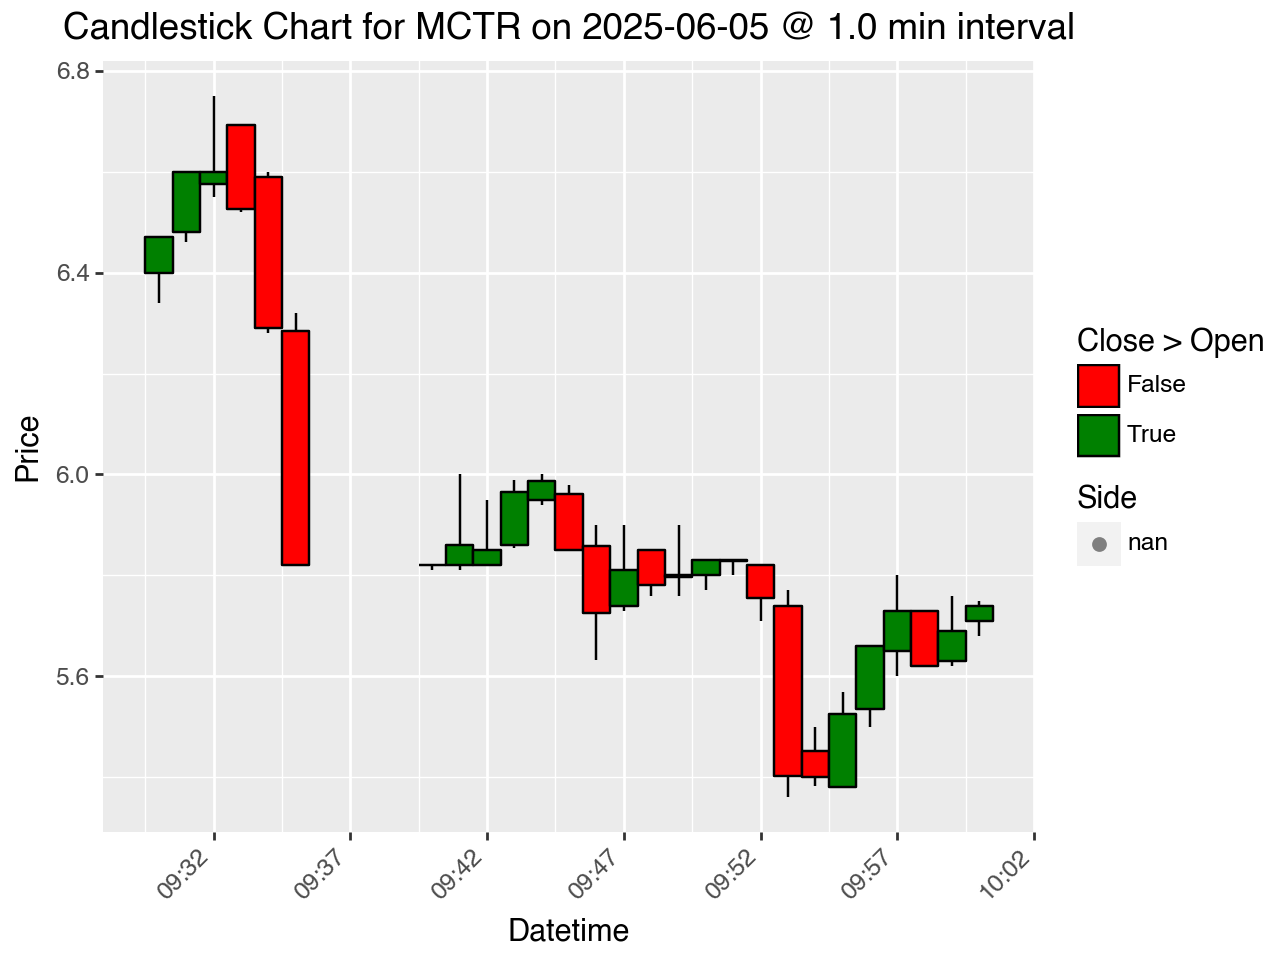

In [ ]:
# plot a given Stock's candlestick chart with buy/sell orders, using an empty order file as the joined orders
tmp=get_stock_data_alpha("MCTR",  stock_interval="1min", download_file_path="/Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/MCTR_TEST_1m.tsv", api_key=ALPHA_ADVANTAGE_KEY)
tmp.to_csv("/Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/MCTR_TEST_1m.tsv", index=False, sep="\t")
tmp_filt= filter_stock(tmp, start_time="09:30:00", end_time="10:00:00", time_column='Datetime')
tmp_filt=tmp_filt[tmp_filt['stock_date']=="2025-06-06"]

#tmp.to_csv("tmp_filtered.csv",index=False,sep="\t")

test_records = pd.read_csv("/Users/stevensmith/Projects/Random_Projects/stock_reccomender/empty_order.tsv")
stock_orders_empty = format_orders(test_records)

tmp2 = combine_data(tmp_filt,stock_orders_empty,direction='backward',stock_key='Datetime', order_key='FilledTime')
display(tmp2)

generate_candlestick_plot(tmp2, timedata_width=0.5, date="2025-06-05", stock_symbol="MCTR")


Get historical stock data


# Compare with stock price

In [ ]:
dates = filter_stock_orders(filled_orders_filtered,cutoff_date="2025-06-05")['Date'].unique()
tmp1 = tmp2 = ""
#dates = filled_orders_w_stats_mlindx[('Date',)  ].unique()
for start_date in dates:
    # Filter the DataFrame for the current date
    #filtered_df = filled_orders_filtered[filled_orders_filtered['FilledTime'].dt.date == start_date]
    filtered_df = filled_orders_filtered[filled_orders_filtered['Date'] == start_date]
    
    for selected_symbol in filtered_df['Symbol'].unique():
        #print(f"Orders for {selected_symbol}:")
        filtered_synbol_date_df = filtered_df[filtered_df['Symbol'] == selected_symbol]
        end_date = start_date + pd.Timedelta(days=1)

        interval_mins = 1 # TODO: make this a parameter/data validation

        interval = f"{interval_mins}min"
        stock_fn = f"/Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/new/stock_order_{start_date}_{selected_symbol}_{interval}.tsv"

        # SWAP OUT FOR ALPHA VANTAGE
        #stock_dat = get_stock_data_wrapper(selected_symbol, start_date=start_date, end_date=end_date, stock_interval=interval,download_file_path=stock_fn, dl_info=True)#,load_from_file=stock_fn)
        stock_dat = get_stock_data_alpha(selected_symbol, stock_interval=interval,api_key=ALPHA_ADVANTAGE_KEY,download_file_path=stock_fn)#,load_from_file=stock_fn)

        #filled_orders[filled_orders['Symbol']==selected_symbol].to_csv(f"stock_order_df_{start_date}_{selected_symbol}.tsv", index=False,sep="\t")
        #TODO: fix loading from previous file. I think the date/time format is not being correctly loaded
        tmp1 = stock_dat
        tmp2 = filtered_synbol_date_df


        stock_order_df = combine_data(stock_dat, filtered_synbol_date_df,tol_interval=interval,direction='backward',stock_key='Datetime', order_key='FilledTime')

        if stock_order_df is not None:

            stock_order_df.loc[stock_order_df['Side']=='Buy','AvgPrice'] = -stock_order_df.loc[stock_order_df['Side']=='Buy','AvgPrice']

            stock_order_df.to_csv(f"stock_order_price_df_{start_date}_{selected_symbol}.tsv", index=False,sep="\t")

            generate_candlestick_plot(filter_time_window(stock_order_df),timedata_width=interval_mins/2,date=start_date ,stock_symbol=selected_symbol)
        else:
            print(f"Stock data for {selected_symbol} on {start_date} not found. Skipping candlestick plot generation.")
            continue


ValueError: Error fetching data for CRCL: Invalid API call. Please retry or visit the documentation (https://www.alphavantage.co/documentation/) for TIME_SERIES_INTRADAY.

In [192]:
get_stock_data_alpha("CRCL", stock_interval="1min",api_key=ALPHA_ADVANTAGE_KEY,download_file_path="foo")#,load_from_file=stock_fn)


API call limit reached. Please try again later.


# Sandbox

Verify candlestick charts match Webull's
Add more functionality to charts - filter by time
Get side-by-side to work 

Buy 3 shares
Sell 1 -
Sell 1 +
Buy 2
Sell 1 -
Sell 2 -

Summarize: 
- Per day & per stock gain/loss
- Accuracy 
-Gain / loss ratio 
- Success metrics (accuracy and gain/loss) by:
 - Time of day
 - Market cap
 - Price
 - Float 
 - Number of trades

{'Meta Data': {'1. Information': 'Intraday (1min) open, high, low, close prices and volume',
  '2. Symbol': 'MCTR',
  '3. Last Refreshed': '2025-06-04 19:59:00',
  '4. Interval': '1min',
  '5. Output Size': 'Full size',
  '6. Time Zone': 'US/Eastern'},
 'Time Series (1min)': {'2025-06-04 19:59:00': {'1. open': '24.8500',
   '2. high': '24.9000',
   '3. low': '24.6000',
   '4. close': '24.6097',
   '5. volume': '7757'},
  '2025-06-04 19:58:00': {'1. open': '24.6600',
   '2. high': '24.9000',
   '3. low': '24.4200',
   '4. close': '24.8500',
   '5. volume': '2472'},
  '2025-06-04 19:57:00': {'1. open': '24.8000',
   '2. high': '24.9600',
   '3. low': '24.3000',
   '4. close': '24.3000',
   '5. volume': '5735'},
  '2025-06-04 19:56:00': {'1. open': '24.2500',
   '2. high': '24.8900',
   '3. low': '24.1400',
   '4. close': '24.7600',
   '5. volume': '3976'},
  '2025-06-04 19:55:00': {'1. open': '24.2000',
   '2. high': '24.3000',
   '3. low': '24.0300',
   '4. close': '24.1300',
   '5. vol

,Datetime,Open,High,Low,Close,Volume
0,2025-06-04 19:59:00-04:00,24.8500,24.9000,24.6000,24.6097,7757
1,2025-06-04 19:58:00-04:00,24.6600,24.9000,24.4200,24.8500,2472
2,2025-06-04 19:57:00-04:00,24.8000,24.9600,24.3000,24.3000,5735
3,2025-06-04 19:56:00-04:00,24.2500,24.8900,24.1400,24.7600,3976
4,2025-06-04 19:55:00-04:00,24.2000,24.3000,24.0300,24.1300,2679
...,...,...,...,...,...,...
2100,2025-05-06 12:35:00-04:00,6.7300,6.7300,6.7300,6.7300,100
2101,2025-05-06 12:31:00-04:00,6.7300,6.7300,6.6898,6.6898,400
2102,2025-05-06 09:58:00-04:00,6.6173,6.6173,6.6173,6.6173,1000
2103,2025-05-06 09:55:00-04:00,6.5184,6.5184,6.5184,6.5184,530
